In [1]:
# Traditional Benchmark: Predicting Recession with Raw Features

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [18]:
# Load dataset
df = pd.read_csv("selected_features_83_w_rare_events.csv")
df['date'] = pd.to_datetime(df['date'])

# Drop non-feature columns
y = df['nber_recession_flag']
X = df.drop(columns=['date', 'nber_recession_flag', 'market_stress_flag', 'market_shock_flag'])

In [5]:
# Sort by date
df = df.sort_values('date')

# Create temporal split (e.g., train on 80%, test on most recent 20%)
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

X_train = train.drop(columns=['date', 'nber_recession_flag', 'market_stress_flag', 'market_shock_flag'])
y_train = train['nber_recession_flag']
X_test = test.drop(columns=['date', 'nber_recession_flag', 'market_stress_flag', 'market_shock_flag'])
y_test = test['nber_recession_flag']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [7]:
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [9]:
# Predict and evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
[[1447    0]
 [ 212    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1447
           1       0.00      0.00      0.00       212

    accuracy                           0.87      1659
   macro avg       0.44      0.50      0.47      1659
weighted avg       0.76      0.87      0.81      1659

ROC AUC: 0.4446056251711413


/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

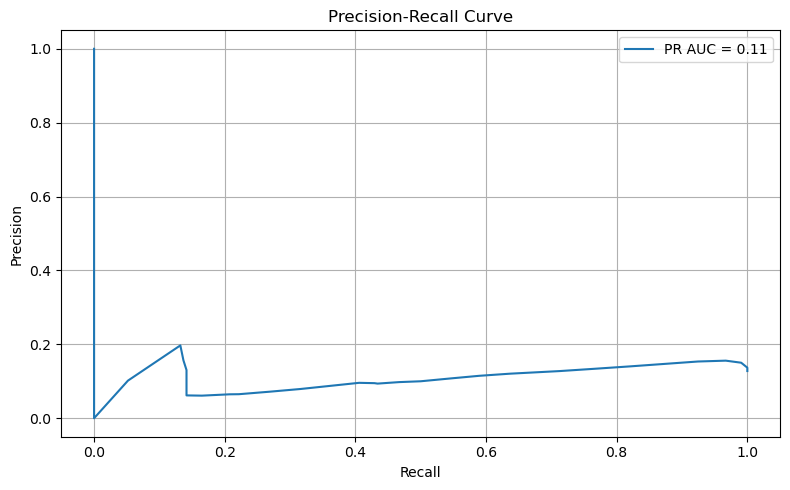

In [11]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

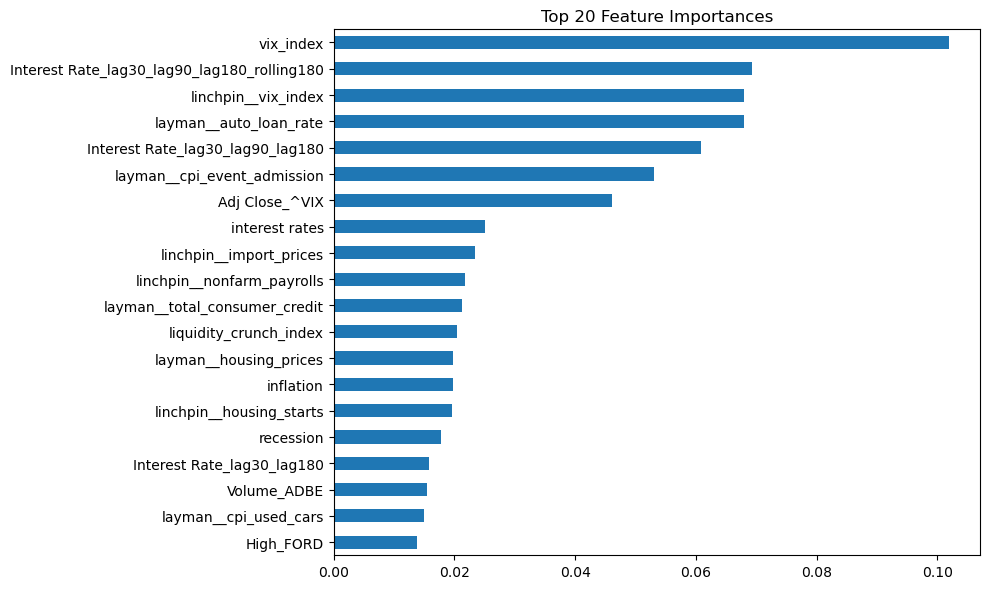

In [15]:
# Feature Importance
importances = clf.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)[:20]
plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

🧠 Rare Event Detection: Why We Go Beyond the Benchmark

🚫 Limitations of Traditional Models

Traditional machine learning approaches often fail in rare event detection — especially in economic forecasting contexts such as predicting recessions.

Key reasons include:
	•	Class Imbalance: Recession periods represent a small fraction of total data. Standard models tend to optimize for accuracy by always predicting the majority class (non-recession).
	•	Temporal Leakage: Random shuffling violates the chronological structure of macroeconomic data, leading to overfitting and unrealistically high performance in benchmarks.
	•	Lack of Generalization: Traditional models lack the ability to reason by analogy — they can’t detect when a new observation looks like a past pre-recession period.
	•	Feature Overload: Using all raw features without transformation increases variance and reduces signal-to-noise ratio, making the model brittle.

⸻

✅ Our Solution: Latent-Space Forecasting with Causal Diagnostics

To overcome these limitations, we propose a robust, multi-stage approach:

1. Temporal Extrapolation

We forecast future values of macroeconomic indicators using ARIMA-based time series modeling to simulate realistic near-future scenarios.

2. PCA Transformation

We compress the high-dimensional feature space into a low-dimensional latent space (e.g., 15 components), removing noise while retaining the most critical variance in the data.

3. Latent Rare Event Detection

In this compressed space, we train a model to detect rare events (e.g., nber_recession_flag). This latent representation allows better generalization and reduces the risk of overfitting.

4. Causal Diagnostics via PCA Loadings

When a rare event is predicted, we reverse-map the prediction through the PCA component matrix to identify the top contributing raw features. This offers interpretability and causal insight.

5. Similarity-Based Flagging

We calculate cosine similarity between projected latent vectors of new data and historical rare event windows. If the similarity crosses a threshold, we flag the observation — even if the classifier is unsure.

⸻

🎯 Why This Matters
	•	Our system doesn’t just say “something bad might happen.”
	•	It explains “why it might happen,” based on which economic pressures are driving the signal.
	•	It identifies “what past events it resembles,” enabling analysts to act with historical context.

⸻